# Assignment 3
```Berle, Bastian```
```Holzapfel, Ron```

## Imports
- Import packages
- Set options

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from joblib import dump

pd.set_option('display.max_columns', None)

## Read data and first overview

In [2]:
df = pd.read_csv('data/temperature.csv', parse_dates=['datetime'])
df = df[['datetime', 'Portland']]

In [3]:
df.head()

,datetime,Portland
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,282.080000
2,2012-10-01 14:00:00,282.083252
3,2012-10-01 15:00:00,282.091866
4,2012-10-01 16:00:00,282.100481


In [4]:
df.describe()

,Portland
count,45252.000000
mean,284.992929
std,7.452438
min,262.370000
25%,279.850000
50%,284.320000
75%,289.451750
max,312.520000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  45253 non-null  datetime64[ns]
 1   Portland  45252 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 707.2 KB


In [6]:
df.nunique()

datetime    45253
Portland    15279
dtype: int64

In [7]:
df.isnull().sum()

datetime    0
Portland    1
dtype: int64

In [8]:
df.dropna(inplace=True) # first entry has no value
df.reset_index(inplace=True)

In [9]:
type(df['datetime'].loc[1])

pandas._libs.tslibs.timestamps.Timestamp

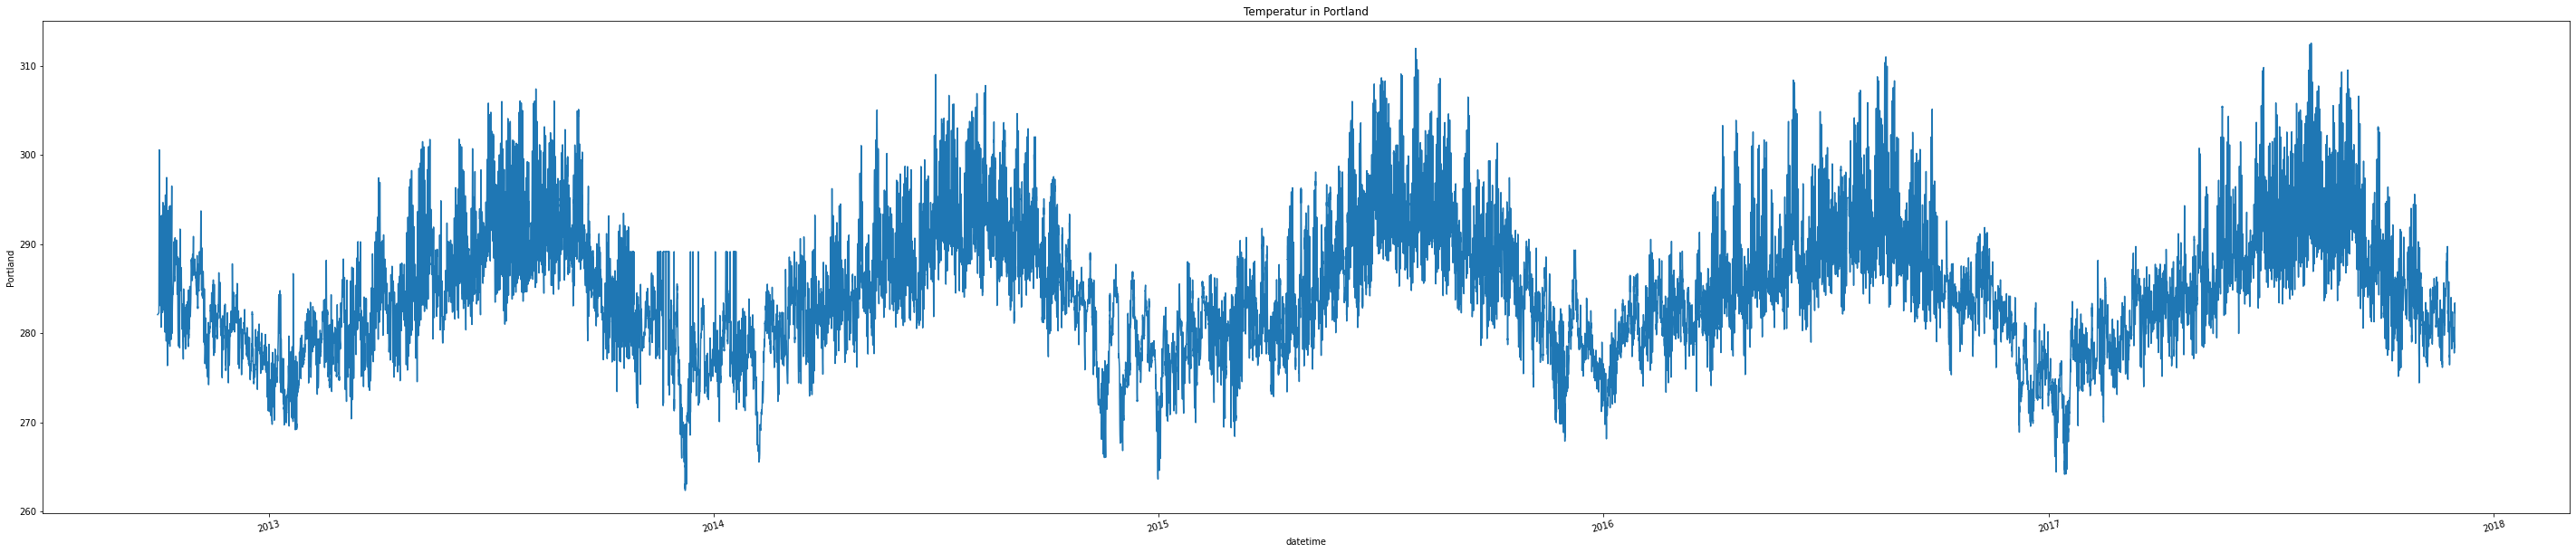

In [38]:
sns.lineplot(x="datetime", y="Portland", data=df)
plt.rcParams['figure.figsize']=(25, 20)
plt.xticks(rotation=15)
plt.title('Temperatur in Portland')
plt.show()

## Extract Test Data

In [10]:
train = df[df['datetime'] < '2016-11-30 00:00:00'].copy()
train.reset_index(inplace=True)
train.drop(columns=['index', 'level_0'], inplace=True)

In [11]:
train.head()

,datetime,Portland
0,2012-10-01 13:00:00,282.080000
1,2012-10-01 14:00:00,282.083252
2,2012-10-01 15:00:00,282.091866
3,2012-10-01 16:00:00,282.100481
4,2012-10-01 17:00:00,282.109095


In [14]:
test = df[df['datetime'] >= '2016-11-30 00:00:00'].copy()
test.reset_index(inplace=True)
test.drop(columns=['index', 'level_0'], inplace=True)

In [15]:
test.head()

,datetime,Portland
0,2016-11-30 00:00:00,284.15
1,2016-11-30 01:00:00,283.29
2,2016-11-30 02:00:00,281.44
3,2016-11-30 03:00:00,280.87
4,2016-11-30 04:00:00,280.27


## Data Preparation

In [16]:
# returns a list of all entries converted in batches of size 5 with the according next value
# e.g. 
# X: [[1, 2, 3, 4, 5],
# [2, 3, 4, 5, 6],
# [3, 4, 5, 6, 7]],
# y: [6, 7, 8]
def make_batches(df, step_size=5):
    idx = 0
    X = []
    y = []
    while(idx+step_size < len(df)-2):
        X.append(np.array(df['Portland'].iloc[idx:idx+step_size]))
        y.append(df['Portland'].iloc[idx+step_size])
        print(f'{idx}/{len(df)} = {idx/len(df)}', end='\r')
        idx += 1
    return np.array(X), np.array(y)

In [ ]:
X, y = make_batches(train) # create batches of 5 entries to predict the next one

In [ ]:
X_test, y_test = make_batches(test)

## Simple Model
The Model predicts the next value based on the five values before using some weigths.

In [20]:
# weigths from old to latest entry
def knn_date(mini_df, weigths):
    arr = np.array(mini_df['Portland'])
    pred = np.dot(np.flip(weigths), arr)
    return pred

In [21]:
def make_batches(df, weigths, step_size=5):
    idx = 0
    delta = []
    while(idx+step_size < len(df)-2):
        pred = knn_date(df.iloc[idx:idx+step_size], weigths)
        delta.append(pred - df['Portland'].iloc[idx+step_size])
        print(f'{idx}/{len(df)} = {idx/len(df)}', end='\r')
        idx += 1
    return(delta)

In [ ]:
predictions = make_batches(test, weigths=np.array([1, 0, 0, 0, 0]))

In [23]:
np.sqrt(sum(np.array(predictions)**2)/len(predictions)) # we achieved the best result using this model by saying that the last value will be the next

1.0983171217020646

## Model using SVM (*bad Example*)

In [195]:
model = SVR(kernel="poly", C=100, gamma="auto", degree=2, epsilon=0.1, coef0=1).fit(X, y)

In [197]:
model.score(X_test, y_test)

-187299589.92615107

In [198]:
predicted = model.predict(X_test) - y_test

In [200]:
np.sqrt(sum(np.array(predicted)**2)/len(predicted))

110198.46823720011

## ARIMA

In [33]:
history = train['Portland'].values.tolist()
predictions = []
model = sm.tsa.arima.ARIMA(history, order=(5,1,0)).fit()
length = len(test)
for t in range(length):
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Portland'].loc[t]
    model = model.append([obs], refit=False)
    print(f'predicted={yhat}, expected={obs}, {t/length}')

predicted=284.1983862100822, expected=284.15, 0.0
predicted=284.476973155768, expected=283.29, 0.0001141422212076247
predicted=283.32811197845564, expected=281.44, 0.0002282844424152494
predicted=280.7720742637454, expected=280.87, 0.0003424266636228741
predicted=279.9480192969425, expected=280.27, 0.0004565688848304988
predicted=279.6437111736824, expected=280.3, 0.0005707111060381235
predicted=280.1695437076338, expected=280.72, 0.0006848533272457482
predicted=280.91577714613214, expected=280.59, 0.0007989955484533729
predicted=280.7792379943463, expected=280.58, 0.0009131377696609977
predicted=280.6850638641418, expected=280.87, 0.0010272799908686223
predicted=280.87954318596013, expected=281.15, 0.001141422212076247
predicted=281.2433999020776, expected=281.15, 0.0012555644332838717
predicted=281.30368563626985, expected=281.15, 0.0013697066544914964
predicted=281.1955341832414, expected=280.86, 0.0014838488756991211
predicted=280.7659113008067, expected=280.72, 0.00159799109690674

Test MSE: 0.8392387797469942


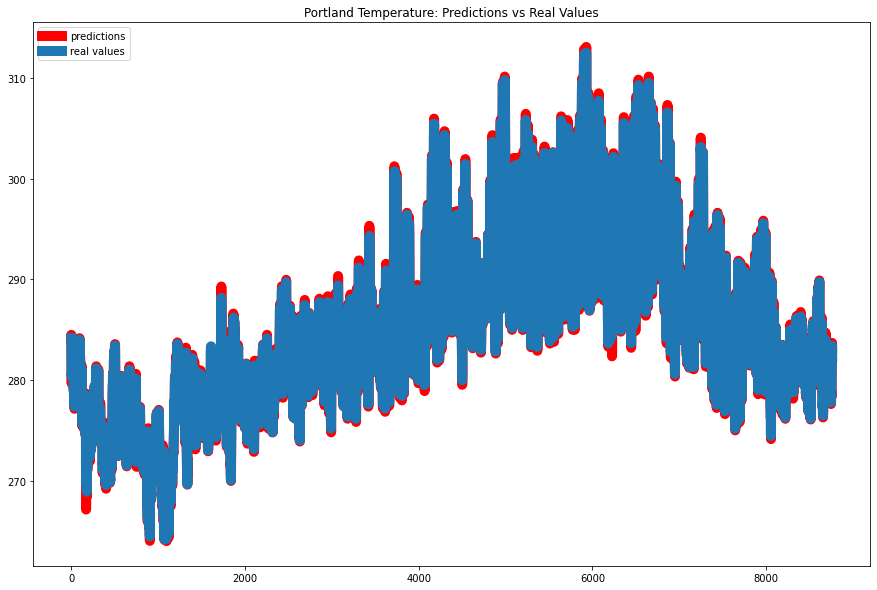

In [87]:
error = mean_squared_error(test['Portland'], predictions, squared=False)
print(f'Test MSE: {error}')
# plot
plt.rcParams['figure.figsize']=(15, 10)
plt.plot(predictions, color='r', linewidth=10, label='predictions')
plt.plot(test['Portland'], linewidth=10, label='real values')
plt.legend(loc="upper left")
plt.title('Portland Temperature: Predictions vs Real Values')
plt.show()